# Balancing a "cart-pole" inverse pendulum using NESTML

In this tutorial, we are going to build an agent that can successfully solve the classic pole balancing problem using reinforcement learning. We will start with a standard temporal difference learning approach and after that, use NESTML to set up a spiking neural network to perform this task.

# Cart Pole Environment

For the cart pole environment, we mostly need three things:  
    - A renderer to display the simulation  
    - The physics system and  
    - An input to be able to nudge the pole in both directions  

For that, we will need the following packages:

In [3]:
%matplotlib inline

from typing import Tuple

import sys
import pygame as pg
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

pygame 2.5.0 (SDL 2.28.0, Python 3.11.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Physics of the inverse pendulum

For the physics, we use the corrected version of of the original problem derived from V. Florian (CITATION NEEDED), but omit the friction forces.
The situation is sketched here:  

![alt text](cartpole_illustration.png "Cartpole")

We apply Newton's second law of motion to the cart:  
$$
\begin{aligned}
    \mathbf{F} + \mathbf{G}_c - \mathbf{N} = m_c \cdot \mathbf{a}_c
\end{aligned}
$$
Where:  

$\mathbf{F} = F \cdot \mathbf{u_x}$ is the control force acting on the cart,  
$\mathbf{G}_c = m_c \cdot g \cdot \mathbf{u}_y$ is the gravitational component acting on the cart,  
$\mathbf{N} = N_x \cdot \mathbf{u}_x - N_y \cdot \mathbf{u}_y$ is the negative reaction force that the pole is applying on the cart,  
$\mathbf{a}_c = \ddot{x} \cdot \mathbf{u}_x$ is the accelaration of the cart,  
$m_c$ is the cart's mass and  
$\mathbf{u}_x$, $\mathbf{u}_y$, $\mathbf{u}_z$ are the unit vectors of the frame of reference given in the illustration.

We can decompose this equation now into the $x$ and $y$ component:
$$
\begin{aligned}
    F - N_x = m_c \cdot \ddot{x}
\end{aligned}
$$
$$
\begin{aligned}
    m_c \cdot g + N_y = 0
\end{aligned}
$$

Newton's second law of motion applied to the pole gives us:
$$
\begin{aligned}
    \mathbf{N} + \mathbf{G}_p = m_p \cdot \mathbf{a}_p
\end{aligned}
$$

Where $\mathbf{G}_p = m_p \cdot g \cdot \mathbf{u}_y$.

The accelaration $\mathbf{a}_p$ of the pole's center of mass consists of three components, where $\mathbf{r}_p = l \cdot (\sin{\theta}\cdot \mathbf{u}_x-\cos{\theta}\cdot \mathbf{u}_y)$ denotes the vector pointing to the pole's center of mass relative to it's rotation center:  
1. The accelaration of the cart it is attached to $\mathbf{a}_c$,
2. The pole's angular accelaration $\mathbf{\epsilon} = \ddot{\theta} \cdot \mathbf{u}_z$, which is translated into accelaration by $\mathbf{\epsilon} \times \mathbf{r}_p$.
3. The pole's angular velocity $\mathbf{\omega} = \dot{\theta} \cdot \mathbf{u}_z$, for which the accelaration can be derived by  $\mathbf{\omega} \times (\mathbf{\omega} \times \mathbf{r}_p)$.

Thus we obtain:
$$
\begin{aligned}
    \mathbf{a}_p  = \mathbf{a}_c + \mathbf{\epsilon} \times \mathbf{r}_p + \mathbf{\omega} \times (\mathbf{\omega} \times \mathbf{r}_p)
\end{aligned}
$$
Substituting $\mathbf{r}_p = l \cdot (\sin{\theta}\cdot \mathbf{u}_x-\cos{\theta}\cdot \mathbf{u}_y)$ and $\mathbf{a}_p = \ddot{x} \cdot \mathbf{u}_x$ as well as $\mathbf{u}_z \times \mathbf{u}_x = \mathbf{u}_y$ and $\mathbf{u}_z \times \mathbf{u}_y = -\mathbf{u}_x$:
\begin{aligned}
    \mathbf{a}_p  = \ddot{x} \cdot \mathbf{u}_x + l \cdot \ddot{\theta} \cdot (\sin{\theta}\cdot \mathbf{u}_y + \cos{\theta}\cdot \mathbf{u}_x) - l \cdot \dot{\theta}^2 \cdot (\sin{\theta}\cdot \mathbf{u}_x - \cos{\theta}\cdot \mathbf{u}_y)
\end{aligned}

Inserting this quation into our equation for the forces of the pole and decomposing on the $x$ and $y$ axis we obtain:
$$
\begin{aligned}
    N_x = m_p \cdot (\ddot{x} + l \cdot \ddot{\theta} \cdot \cos{\theta} - l \cdot \dot{\theta}^2 \cdot \sin{\theta})
\end{aligned}
$$
$$
\begin{aligned}
    m_p \cdot g - N_y = m_p \cdot (l \cdot \ddot{\theta} \cdot \sin{\theta} + l \cdot \dot{\theta}^2 \cdot \cos{\theta})
\end{aligned}
$$

To render the environment for visual inspection, we make a class ``Renderer`` that uses pygame:

Physics is implemented in a class ``Physics``:

In [4]:
class Physics():
    
    def __init__(self, x, theta, v = 0, a = 0, w = 0, dw = 0, g = 9.81, m_c = 1, m_p = 0.1, l = 0.5, dt = 0.02) -> None:
        self.__dict__.update(vars())

    def dw_step(self, cart_force, nudge_force) -> float:
        numerator = self.g * np.sin(self.theta) + np.cos(self.theta) * (-cart_force - self.m_p * self.l * self.w**2 * np.sin(self.theta))/(self.m_c+self.m_p) + nudge_force * np.cos(self.theta)/(self.m_p*self.l)
        denominator = self.l * (4/3 - (self.m_p*np.cos(self.theta)**2)/(self.m_c+self.m_p))

        self.dw = numerator/denominator
        self.w += self.dt * self.dw
        self.theta += self.dt * self.w

        return self.theta
    
    def a_step(self, force) -> float:
        numerator = force + self.m_p * self.l * (self.w**2 * np.sin(self.theta) - self.dw * np.cos(self.theta))
        denominator = self.m_c + self.m_p

        self.a = numerator/denominator
        self.v += self.dt * self.a
        self.x += self.dt * self.v

        return self.x

    def update(self, force, mouse_x) -> Tuple[float, float]:
        nudge_force = 0
        if mouse_x is not None:
            nudge_force = -10 if mouse_x > self.x else 10
        return (self.dw_step(force, nudge_force), self.a_step(force))
    
    #get state of the system that agent can see
    def get_state(self) -> Tuple[float,float,float,float]:
        return (self.x, self.theta, self.v, self.w)
    
    def reset(self) -> None:
        self.x = 0
        self.theta = (np.random.rand() - 1) / 10
        self.v = 0
        self.a = 0
        self.w = 0
        self.dw = 0


In [5]:
#Renders the scene. IMPORTANT: Because ipycanvas uses the html canvas coordinates, the y-axis is inverted.
class Renderer():
    def __init__(self, width: int, height: int, origin_x: int = 0, origin_y: int = 0, SCALE: int = 1) -> None:
        self.width = width
        self.height = height
        self.origin = (origin_x, origin_y)
        self.SCALE = SCALE #1m = SCALE pixels

        pg.display.init()
        pg.display.set_caption("Pole Balancing Simulator")
        pg.font.init()
        self.screen = pg.display.set_mode((width, height))
    
    #Translates global coordinates into screen coordinates
    def translate(self, x: int, y: int) -> Tuple[int, int]:
        return (x+self.origin[0], -y+self.origin[1])
    
    #Draws ground. offset is there to shift the ground below the car
    def draw_ground(self, offset: int, color) -> None:
        ground = pg.Rect(self.translate(-self.width//2, -offset * self.SCALE), (self.width, self.height-self.origin[1]-offset * self.SCALE))
        pg.draw.rect(self.screen, color, ground)

    #Draws car. pos_y is omitted because the car's center should be at y = 0
    def draw_car(self, pos_x: float, car_color = "blue", wheel_color = "black") -> None:
        pos_x *= self.SCALE
        #values, hard-coded for now, in meters
        width = 0.5 * self.SCALE
        height = 0.25 * self.SCALE
        wheel_radius = 0.1 * self.SCALE

        car_body = pg.Rect(self.translate(pos_x - width/2, height/2), (width, height))
        pg.draw.rect(self.screen, car_color, car_body)
        pg.draw.circle(self.screen, wheel_color, 
                           self.translate(pos_x - width/2 + wheel_radius, -height/2), wheel_radius)
        pg.draw.circle(self.screen, wheel_color, 
                           self.translate(pos_x + width/2 - wheel_radius, -height/2), wheel_radius)

    #Draws the pole
    def draw_pole(self, pos_x: float, theta: float, length: float, width: float = 0.1, color = "red") -> None:
        pos_x *= self.SCALE
        width = int(width * self.SCALE)
        pole_end_x = length * np.sin(theta) * self.SCALE + pos_x
        pole_end_y = length * np.cos(theta) * self.SCALE
        pg.draw.line(self.screen, color, self.translate(pos_x, 0), self.translate(pole_end_x, pole_end_y), width)

    #Clears the entire canvas
    def draw_clear(self) -> None:
        self.screen.fill("white")

    #Draws physical values
    def draw_stats(self, theta: float, dw: float, a: float, x: float, episode: int) -> None:
        font = pg.font.Font(None, 24)
        text = font.render(str(theta)[:4] + " | " + str(dw)[:4] + " | " + str(x)[:4] + " | " + str(a)[:4] + " | episode: " + str(episode), True, (10,10,10))
        textpos = text.get_rect(centerx=self.screen.get_width() / 2, y=10)
        self.screen.blit(text, textpos)

    #Get the 
    def get_relative_mouse_x(self, mouse_x:float) -> float:
        return (mouse_x-self.origin[0])/self.SCALE
    
    def display(self) -> None:
        pg.display.flip()

Let's see the physics in action (without an agent controlling the cart yet):

In [4]:
r = Renderer(1200, 800, 600, 500, 400)
clock = pg.time.Clock()
running = True

p = Physics(0, (np.random.rand() - 1) / 10)

steps_per_episode = 0
max_steps = 0

toggle_sim = False

while running:
    steps_per_episode += 1

    force = 0
    mouse_x = None

    # poll for events
    for event in pg.event.get():
        if event.type == pg.QUIT:
            running = False
            pg.quit()
            sys.exit()
            quit()
        elif event.type == pg.MOUSEBUTTONDOWN:
            mouse_x = r.get_relative_mouse_x(pg.mouse.get_pos()[0])

    force = 0   # no controller, no action
    theta, x = p.update(force, mouse_x)
    
    r.draw_clear()
    r.draw_ground(0.2, "grey")
    r.draw_car(x)
    r.draw_pole(x, theta, 2*p.l, 0.02)
    r.draw_stats(theta*180/np.pi, p.w*180/np.pi, x, 0, 0)
    r.display()

    clock.tick(50)  # limits FPS to 50


SystemExit: 

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3386: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# The Agent

In the base class ``Agent``...

"boxes" (discretizing the state space)...

In [6]:
class Agent:
    def __init__(self, initial_state: Tuple[float, float, float, float]) -> None:
        self.x_thresholds = np.array([-2.4, -0.8, 0.8, 2.4])
        self.theta_thresholds = np.array([-12, -6, -1, 0, 1, 6, 12])
        self.theta_thresholds = self.theta_thresholds / 180 * np.pi
        self.v_thresholds = np.array([float("-inf"), -0.5, 0.5, float("+inf")]) #open intervals ignored here
        self.w_thresholds = np.array([float("-inf"), -50, 50, float("+inf")]) #open intervals ignored here
        self.w_thresholds = self.w_thresholds /180 * np.pi

        self.dimensions = (len(self.x_thresholds),
                           len(self.theta_thresholds),
                           len(self.v_thresholds),
                           len(self.w_thresholds))

        self.boxes = np.random.rand(self.dimensions[0], 
                                    self.dimensions[1], 
                                    self.dimensions[2], 
                                    self.dimensions[3], 
                                    2) # one q-value for left and right respectively
        box = self.get_box(initial_state)
        self.current_box = self.boxes[box[0], box[1], box[2], box[3], :]

        self.episode = 1

    def discretize(self, value, thresholds):
        thresholds = np.asarray(thresholds)
        box_idx = np.digitize(value, thresholds)

        if box_idx == 0 or box_idx > len(thresholds) - 1:
            # below the lowest or above the highest threshold
            return -1

        return box_idx - 1
    
    def get_box(self, state: Tuple[float,float,float,float]) -> Tuple[int,int,int,int]:
        return (self.discretize(state[0], self.x_thresholds),
                 self.discretize(state[1], self.theta_thresholds),
                 self.discretize(state[2], self.v_thresholds), 
                 self.discretize(state[3], self.w_thresholds))
    
    def get_episode(self) -> int:
        return self.episode
    
    def failure_reset(self, state: Tuple[float,float,float,float]):
        box = self.get_box(state)
        self.current_box = self.boxes[box[0], box[1], box[2], box[3], :]
        self.episode += 1

Show discretisation:

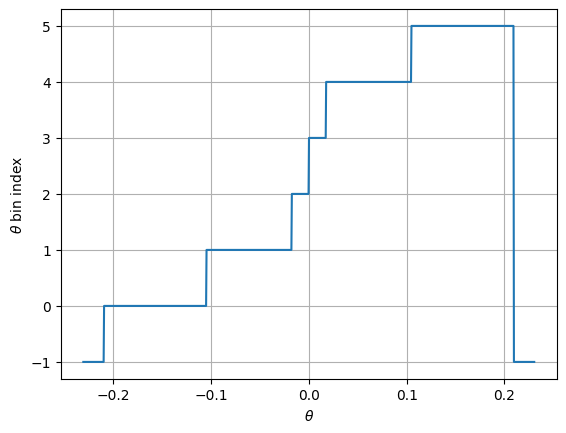

In [7]:
agent = Agent((0,0,0,0))

fig, ax = plt.subplots()
theta_min = np.amin(agent.theta_thresholds)
theta_max = np.amax(agent.theta_thresholds)
theta_range = np.linspace(theta_min - .1 * np.abs(theta_min), theta_max + .1 * np.abs(theta_max), 1000)

theta_idx = np.nan * np.ones_like(theta_range)
for i in range(len(theta_range)):
    theta_idx[i] = agent.discretize(theta_range[i], agent.theta_thresholds)

ax.plot(theta_range, theta_idx)
ax.set_xlabel(r"$\theta$")
ax.set_ylabel(r"$\theta$ bin index")
ax.grid(True)

## Non-spiking version

...

In [8]:
class NonSpikingAgent(Agent):
    def __init__(self, initial_state: Tuple[float,float,float,float], learning_rate, learning_decay, epsilon, epsilon_decay, discount_factor) -> None:
        super().__init__(initial_state)

        #learning paramters
        self.learning_rate = learning_rate
        self.learning_decay = learning_decay
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.discount_factor = discount_factor

    def choose_action(self) -> int:
        r"""
        Returns 0 if the action is "left", else "1"
        """
        self.action = np.random.choice([np.argmax(self.current_box), np.argmin(self.current_box)],
                                       p=[1 - self.epsilon, self.epsilon])
        return self.action
    
    def update(self, next_state: Tuple[float,float,float,float]) -> int:
        r"""
        Returns 0 if no failure occured, else 1.
        
        Reward is -1 on failure and 0 otherwise.
        """
        box = self.get_box(next_state)
        if -1 in box:
            self.current_box[self.action] += self.learning_rate * -1
            return 1
        
        next_box = self.boxes[box[0], box[1], box[2], box[3], :]
        next_q = np.max(next_box)
        self.current_box[self.action] += self.learning_rate * (self.discount_factor * (next_q - self.current_box[self.action]))

        self.current_box = next_box
        self.epsilon *= self.epsilon_decay
        self.learning_rate *= self.learning_decay

        return 0
    

Plot renderer:

In [11]:
#%matplotlib qt
class Non_Spiking_PlotRenderer():
    def __init__(self, init_x = [0], init_y = [0]) -> None:
        #plt.ion()
        #Construct lifetime plot
        self.lifetime_fig, ax = plt.subplots(nrows=2)
        self.lifetime_ax = ax[0]
        self.epsilon_ax = ax[1]
        self.x = init_x
        self.y = init_y
        self.max_lifetime = 0
        self.line, = self.lifetime_ax.plot(self.x, self.y)
        self.lifetime_ax.set_xlabel("Episode")
        self.lifetime_ax.set_ylabel("Simulation Steps")
        self.lifetime_ax.set_title("Lifetime Plot")

        #Construct Heatmap for two parameters
        self.q_value_fig, self.q_value_ax = plt.subplots()
        self.q_value_ax.set_title("Q-Values for a state of (param1/param2)")
        self.cmap = plt.cm.coolwarm
        
    def update(self, x, y, boxes) -> None:
        self.x.append(x)
        self.y.append(y)
        self.max_lifetime = max(self.max_lifetime, y)
        self.line.set_data(self.x, self.y)
        self.lifetime_ax.set_xlim(self.x[0], self.x[-1])
        self.lifetime_ax.set_ylim(0, self.max_lifetime)

        if(x % 10 == 0):
            q_values = boxes[:,:,:,:,0] - boxes[:,:,:,:,1]
            self.q_value_ax.imshow(np.mean(q_values, axis = (1,3)), cmap=plt.cm.coolwarm, interpolation='none')

        self.lifetime_fig.canvas.draw()
        self.lifetime_fig.canvas.flush_events()
        
        display.clear_output(wait=True)
        display.display(self.lifetime_fig)

        #plt.pause(0.0001)


Executing Non-Spiking-Agent:

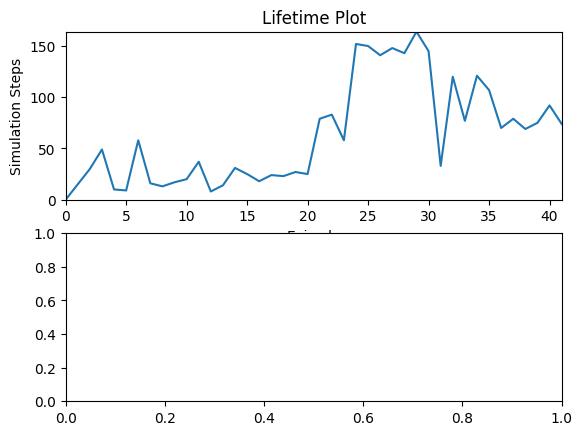

0
1
2
3
4
5
6
7
8
9
10


In [ ]:
%pdb
r = Renderer(1200, 800, 600, 500, 400)
clock = pg.time.Clock()
running = True

p = Physics(0, (np.random.rand() - 1) / 10)

a = NonSpikingAgent(p.get_state(), 0.5, 0.9999999999999, 1, 0.995, 0.99)

plot = Non_Spiking_PlotRenderer()

steps_per_episode = 0
max_steps = 0

window_size = 30
window = np.zeros(30)
avg_lifetime = 20000

toggle_sim = True

while running:
    steps_per_episode += 1

    force = 0
    mouse_x = None

    # poll for events
    for event in pg.event.get():
        if event.type == pg.QUIT:
            running = False
            pg.quit()
            sys.exit()
            quit()
        elif event.type == pg.MOUSEBUTTONDOWN:
            mouse_x = r.get_relative_mouse_x(pg.mouse.get_pos()[0])
        elif event.type == pg.KEYDOWN:
            toggle_sim ^= pg.key.get_pressed()[pg.K_SPACE]

    # agent chooses action, simulation is updated and reward is calculated
    force = 10 if a.choose_action() else -10
    theta, x = p.update(force, mouse_x)
    failure = a.update(p.get_state())

    if failure:
        p.reset()
        a.failure_reset(p.get_state())
        plot.update(a.get_episode(), steps_per_episode, a.boxes)
        window = np.roll(window, 1)
        window[0] = steps_per_episode
        steps_per_episode = 0
    
    
    if np.mean(window) >= avg_lifetime or toggle_sim:
        r.draw_clear()
        r.draw_ground(0.2, "grey")
        r.draw_car(x)
        r.draw_pole(x, theta, 2*p.l, 0.02)
        r.draw_stats(theta*180/np.pi, p.w*180/np.pi, x, p.a, a.get_episode())
        r.display()

        clock.tick(50)  # limits FPS to 50

# TODO: clean up code, derive equations and explain renderer briefly

In [ ]:
pass

# Spiking version

## Idea

The core principle of our SNN is to simulate the physics and neuron model in sequence, where the state at the end of a physics step is the input for the SNN and the resulting action at the end of a period of SNN simulation is the input to the next physics simulation. Both cycles are set to 40ms to provide the effect that they run simultaneously.
The model's structure consists of two layers of neurons. For each discrete state of the system, the input layer contains a single neuron corresponding to it. Neuromodulated synapses connect these to the output layer, which itself consists of two neuron groups interpreted as actions "move left" and "move right" respectively.

One simulation step of the SNN works as follows:
1. Get the current state of the cart pole and find the designated neuron that only fires when that state is reached.
2. Set a continuous firing rate for the simulation period on that neuron.
3. Determine which of the neuron groups in the output layer has fired more spikes at the end of the step.

# SNN Visualization

In [1]:
class Spiking_PlotRenderer():
    def __init__(self) -> None:

        plt.ion()
        
        self.fig, self.ax = plt.subplots(nrows=2)
        
        # Top plot for spikes
        self.ax[0].set_xlabel("Time [ms]")
        self.ax[0].set_yticks([])  # No Y-ticks
        self.ax[0].set_title("Input Spikes")
        self.ax[0].set_xlim(0, 40)  # Set the x-axis limits
        
        # Bottom plot for membrane potential
        self.ax[1].set_ylabel("V_m [mV]")
        self.ax[1].set_xlabel("Time [ms]")
        self.ax[1].set_xlim(0, 40)  # Set the x-axis limits
        self.ax[1].invert_yaxis()
        
        self.fig.show()
        
    def update(self, data) -> None:
        if data is None: return

        self.ax[0].cla()
        self.ax[1].cla()

        self.ax[0].plot(data["input_spikes"]["times"], data["input_spikes"]["senders"], ".k", markersize=1)
        self.ax[0].set_xlim(np.min(data["multimeter_right_events"]["times"]), np.max(data["multimeter_right_events"]["times"]))
        
        self.ax[1].plot(data["multimeter_right_events"]["times"], data["multimeter_right_events"]["V_m"], 'r')
        self.ax[1].plot(data["multimeter_left_events"]["times"], data["multimeter_left_events"]["V_m"], 'b')
        self.ax[1].set_xlim(np.min(data["multimeter_right_events"]["times"]), np.max(data["multimeter_right_events"]["times"]))
        
        self.fig.canvas.draw()
        self.fig.canvas.flush_events()
        
        plt.pause(0.0001)

## Neuron Models

### Ignore and Fire Neuron

In [8]:
# ... generate NESTML model code...

from pynestml.codegeneration.nest_code_generator_utils import NESTCodeGeneratorUtils

# generate and build code
input_layer_module_name, input_layer_neuron_model_name = \
   NESTCodeGeneratorUtils.generate_code_for("../../../models/neurons/ignore_and_fire_neuron.nestml")

# ignore_and_fire
output_layer_module_name, output_layer_neuron_model_name, output_layer_synapse_model_name = \
    NESTCodeGeneratorUtils.generate_code_for("iaf_psc_exp_neuron.nestml",
                                             "neuromodulated_stdp_synapse.nestml",
                                             post_ports=["post_spikes"],
                                             logging_level="DEBUG",
                                             codegen_opts={"delay_variable": {"neuromodulated_stdp_synapse": "d"},
                                                           "weight_variable": {"neuromodulated_stdp_synapse": "w"}})



              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0
 Built: Aug 27 2024 04:38:39

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0
 Built: Aug 27 2024 04:38:39

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.

[15,ignore_and_fire_neuron_nestml, WARNING, [35:34;35:58]]: Model contains a call to fixed-timestep functions (``resolution()`` and/or ``steps()``). This restricts the model to being compatible only with fixed-timestep simulators. Consider eliminating ``resolution()`` and ``steps()`` from the model, and using ``timestep()`` instead.
CMake

INFO:root:Analysing input:
INFO:root:{
    "dynamics": [
        {
            "expression": "g_e' = (-g_e) / tau_g",
            "initial_values": {
                "g_e": "0.0"
            }
        },
        {
            "expression": "V_m' = (g_e * (E_e - V_m) + E_l - V_m + I_e + I_stim) / tau_m",
            "initial_values": {
                "V_m": "E_l"
            }
        }
    ],
    "options": {
        "output_timestep_symbol": "__h"
    },
    "parameters": {
        "E_e": "0",
        "E_l": "(-74)",
        "I_e": "0",
        "V_reset": "(-60)",
        "V_th": "(-54)",
        "s": "1000",
        "tau_g": "5",
        "tau_m": "10"
    }
}
INFO:root:Processing global options...
INFO:root:Processing input shapes...
INFO:root:
Processing differential-equation form shape g_e with defining expression = "(-g_e) / tau_g"
DEBUG:root:Splitting expression -g_e/tau_g (symbols [g_e])
DEBUG:root:	linear factors: Matrix([[-1/tau_g]])
DEBUG:root:	inhomogeneous term: 0.0
DEBUG:

[51,iaf_psc_exp_neuron_nestml, WARNING, [42:8;42:17]]: Variable 's' has the same name as a physical unit!
[52,iaf_psc_exp_neuron_nestml, INFO, [39:19;39:19]]: Implicit casting from (compatible) type 'integer' to 'real'.
[53,iaf_psc_exp_neuron_nestml, INFO, [42:17;42:17]]: Implicit casting from (compatible) type 'integer' to 'real'.
[54,iaf_psc_exp_neuron_nestml, INFO, [55:15;55:32]]: Implicit casting from (compatible) type '1 / s buffer' to 'real'.
[55,GLOBAL, INFO]: Analysing/transforming model 'iaf_psc_exp_neuron_nestml__with_neuromodulated_stdp_synapse_nestml'
[56,iaf_psc_exp_neuron_nestml__with_neuromodulated_stdp_synapse_nestml, INFO, [20:0;60:0]]: Starts processing of the model 'iaf_psc_exp_neuron_nestml__with_neuromodulated_stdp_synapse_nestml'


DEBUG:root:	linear factors: Matrix([[-1/tau_g], [0], [0], [0]])
DEBUG:root:	inhomogeneous term: 0.0
DEBUG:root:	nonlinear term: 0.0
DEBUG:root:Created Shape with symbol g_e, derivative_factors = [-1/tau_g], inhom_term = 0.0, nonlin_term = 0
INFO:root:	Returning shape: Shape "g_e" of order 1
INFO:root:
Processing differential-equation form shape V_m with defining expression = "(g_e * (E_e - V_m) + E_l - V_m + I_e + I_stim) / tau_m"
DEBUG:root:Splitting expression (E_l + I_e + I_stim - V_m + g_e*(E_e - V_m))/tau_m (symbols [g_e, V_m, post_trace__for_neuromodulated_stdp_synapse_nestml, g_e, V_m])
DEBUG:root:	linear factors: Matrix([[E_e/tau_m], [-1/tau_m], [0], [0], [0]])
DEBUG:root:	inhomogeneous term: E_l/tau_m + I_e/tau_m + I_stim/tau_m
DEBUG:root:	nonlinear term: -V_m*g_e/tau_m
DEBUG:root:Created Shape with symbol V_m, derivative_factors = [-1/tau_m], inhom_term = E_l/tau_m + I_e/tau_m + I_stim/tau_m, nonlin_term = E_e*g_e/tau_m - V_m*g_e/tau_m
INFO:root:	Returning shape: Shape "V_m" 

[57,iaf_psc_exp_neuron_nestml__with_neuromodulated_stdp_synapse_nestml, WARNING, [42:8;42:17]]: Variable 's' has the same name as a physical unit!
[58,iaf_psc_exp_neuron_nestml__with_neuromodulated_stdp_synapse_nestml, INFO, [39:19;39:19]]: Implicit casting from (compatible) type 'integer' to 'real'.
[59,iaf_psc_exp_neuron_nestml__with_neuromodulated_stdp_synapse_nestml, INFO, [42:17;42:17]]: Implicit casting from (compatible) type 'integer' to 'real'.
[60,iaf_psc_exp_neuron_nestml__with_neuromodulated_stdp_synapse_nestml, INFO, [55:15;55:32]]: Implicit casting from (compatible) type '1 / s buffer' to 'real'.
[61,GLOBAL, INFO]: Analysing/transforming synapse neuromodulated_stdp_synapse_nestml__with_iaf_psc_exp_neuron_nestml.
[62,neuromodulated_stdp_synapse_nestml__with_iaf_psc_exp_neuron_nestml, INFO, [8:0;55:0]]: Starts processing of the model 'neuromodulated_stdp_synapse_nestml__with_iaf_psc_exp_neuron_nestml'
[63,neuromodulated_stdp_synapse_nestml__with_iaf_psc_exp_neuron_nestml, WA

In [9]:
import nest

nest.set_verbosity("M_ERROR")

class SpikingAgent(Agent):
    cycle_period = 40.   # [ms], corresponding to 2 physics steps
    
    def __init__(self, initial_state: Tuple[float,float,float,float], gamma) -> None:
        super().__init__(initial_state)
        self.gamma = gamma
        self.construct_neural_network()
        self.Q_left = None
        self.Q_right = None
        self.Q_left_prev = None
        self.Q_right_prev = None
        self.scale_n_output_spikes_to_Q_value = 100
    
    def get_state_neuron(self, state) -> int:
        idx = 0
        thresholds = [self.x_thresholds, self.theta_thresholds, self.v_thresholds, self.w_thresholds]
        for dim, val, thresh in zip(self.dimensions, state, thresholds):
            i = self.discretize(val,thresh)
            if i == -1:
                return -1
            idx = idx * dim + i

        return idx
    
    def construct_neural_network(self):
        nest.ResetKernel()
        nest.Install(input_layer_module_name)   # makes the generated NESTML model available
        nest.Install(output_layer_module_name)   # makes the generated NESTML model available

        input_size = self.dimensions[0] * self.dimensions[1] * self.dimensions[2] * self.dimensions[3]
        self.input_population = nest.Create(input_layer_neuron_model_name, input_size)
        
        """
        self.volume_transmitter = nest.Create("volume_transmitter")
        nest.CopyModel(output_layer_synapse_model_name, "stdp_dopa_nestml",
                        {"volume_transmitter": self.volume_transmitter}) #how does this work? we're just setting syn.n?
        """
        
        self.output_population_left = nest.Create(output_layer_neuron_model_name, 10)
        self.output_population_right = nest.Create(output_layer_neuron_model_name, 10)
        
        self.spike_recorder_input = nest.Create("spike_recorder")
        nest.Connect(self.input_population, self.spike_recorder_input)

        self.multimeter_left = nest.Create('multimeter', 1, {'record_from': ['V_m']})
        nest.Connect(self.multimeter_left, self.output_population_left)
        self.multimeter_right = nest.Create('multimeter', 1, {'record_from': ['V_m']})
        nest.Connect(self.multimeter_right, self.output_population_right)

        #the random weights do very weird stuff...
        nest.Connect(self.input_population, self.output_population_left, syn_spec={"synapse_model": output_layer_synapse_model_name,})
                                                                                   #'weight': nest.random.normal(mean=0., std=1.),})
        nest.Connect(self.input_population, self.output_population_right, syn_spec={"synapse_model": output_layer_synapse_model_name,})
                                                                                    #'weight': nest.random.normal(mean=0., std=1.),})

        self.output_population_spike_recorder_left = nest.Create("spike_recorder")
        nest.Connect(self.output_population_left, self.output_population_spike_recorder_left)

        self.output_population_spike_recorder_right = nest.Create("spike_recorder")
        nest.Connect(self.output_population_right, self.output_population_spike_recorder_right)

    #returns 0 if the action is "left", else "1"
    def choose_action(self, Q_left, Q_right) -> int:
        return Q_left > Q_right

    def compute_Q_values(self) -> None:
        n_output_spikes_left = self.output_population_spike_recorder_left.n_events
        n_output_spikes_right = self.output_population_spike_recorder_right.n_events
 
        self.output_population_spike_recorder_left.n_events = 0
        self.output_population_spike_recorder_right.n_events = 0
        
        self.Q_left_prev = self.Q_left
        self.Q_right_prev = self.Q_right

        # still need to get scale
        self.Q_left = self.scale_n_output_spikes_to_Q_value * n_output_spikes_left
        self.Q_right = self.scale_n_output_spikes_to_Q_value * n_output_spikes_right

    # update Q_value using TD-Error with previous Q_value and reward = 0
    # cooldown_time in case the SNN doesn't need 40ms to update
    def failure_reset(self, cooldown_time) -> None:
        # if for some reason the simulation terminates super fast
        if self.Q_left_prev == None and self.Q_right_prev == None:
            return
        # what would we mean by that? negative dopamine is biologically inaccurate
        # inhibitory neuromodulators?
        if self.choose_action(self.Q_left_prev, self.Q_right_prev):
            syn = nest.GetConnections(source=self.input_population, target=self.output_population_right)
            syn.n = -self.Q_right
        else:
            syn = nest.GetConnections(source=self.input_population, target=self.output_population_left)
            syn.n = -self.Q_left
        nest.Simulate(cooldown_time)
        
        self.episode += 1

    def update(self, next_state: Tuple[float,float,float,float]) -> Tuple[int, dict]:
        
        # make the correct input neuron fire
        self.input_population.firing_rate = 0.
        neuron_id = self.get_state_neuron(next_state)

        # if state was a failure
        if neuron_id == -1:
            self.failure_reset(SpikingAgent.cycle_period)
            return -1, None
        
        self.input_population[neuron_id].firing_rate = 100. # XXX: value not given in Liu&Pan. Got 500 Hz as max freq from BVogler thesis. n.b. 40 ms cycle time. 
        self.multimeter_left.n_events = 0
        self.multimeter_right.n_events = 0
        self.spike_recorder_input.n_events = 0
        
        # simulate for one cycle
        nest.Simulate(SpikingAgent.cycle_period)
        
        #passed onto Spiking_Plot_Renderer()
        plot_data = {
            "input_spikes": nest.GetStatus(self.spike_recorder_input, keys="events")[0],
            "multimeter_right_events": self.multimeter_right.get("events"),
            "multimeter_left_events": self.multimeter_left.get("events")
        }

        self.compute_Q_values()

        # set new dopamine concentration on the synapses
        # PROBLEM: HOW DO WE HANDLE FAILURE? The physics simulation immediately resets after it.
        # Perhaps run the simulation without spiking to let the weights update? (BVogler)

        # update Q_value using TD-Error with previous Q_value and reward = 1
        if self.Q_left_prev != None and self.Q_right_prev != None:
            R = 1.
            if self.choose_action(self.Q_left_prev, self.Q_right_prev):
                syn = nest.GetConnections(source=self.input_population, target=self.output_population_right)
                syn.n = self.gamma * self.Q_right + R - self.Q_right_prev
            else:
                syn = nest.GetConnections(source=self.input_population, target=self.output_population_left)
                syn.n = self.gamma * self.Q_left + R - self.Q_left_prev
        
        # 0 if action is "left", else 1
        return self.choose_action(self.Q_left, self.Q_right), plot_data
        

In [10]:
#a = SpikingAgent((0,0,0,0), 0.98)
#a.update((0,0,1,0))

# Executing spiking version

The main loop looks like this: for every iteration of the loop (for every "cycle" or "step"):

- set the rate of the input neurons to the current state of the system
- run the SNN with this input state s_n for a period of time (cycle time, in BVogler's thesis: 40 ms)
- obtain the Q(sn, a) values, by counting nr of spikes in output population over this cycle period
- choose action $a_n$ on the basis of Q-values
- run the environment for the same cycle time (40 ms) to obtain next state $s_{n+1}$
- compute reward on the basis of the last taken action (????)

In [11]:
import sys

r = Renderer(1200, 800, 600, 500, 400)
clock = pg.time.Clock()
running = True

p = Physics(0, (np.random.rand() - 1) / 10)

a = SpikingAgent(p.get_state(), 0.98)

plot = Spiking_PlotRenderer()

steps_per_episode = 0

window_size = 30
window = np.zeros(30)
avg_lifetime = 20000

toggle_sim = False
plot_spikes = False
while running:
    steps_per_episode += 1
    force = 0
    mouse_x = None

    # poll for events
    for event in pg.event.get():
        if event.type == pg.QUIT:
            running = False
            pg.quit()
            sys.exit()
            quit()
        elif event.type == pg.MOUSEBUTTONDOWN:
            mouse_x = r.get_relative_mouse_x(pg.mouse.get_pos()[0])
        elif event.type == pg.KEYDOWN:
            #controls if simulation should be shown or not
            toggle_sim ^= pg.key.get_pressed()[pg.K_SPACE]
            plot_spikes ^= pg.key.get_pressed()[pg.K_p]


    # Simulate SNN, choose action, simulate physics, receive state
    # Since SNN takes 40ms, it reacts only to every 2nd physics step
    if steps_per_episode % 2 == 1:
        action, plot_data = a.update(p.get_state())
        if action == -1:
            p.reset()
            a.failure_reset(SpikingAgent.cycle_period)
            window = np.roll(window, 1)
            window[0] = steps_per_episode
            steps_per_episode = 0
        else:
            force = 10 if action else -10
            theta, x = p.update(force, mouse_x)
            
            if plot_spikes:
                plot.update(plot_data)
                plot_spikes = False
    else:
        theta, x = p.update(0, mouse_x)

    
    
    if np.mean(window) >= avg_lifetime or toggle_sim:
        r.draw_clear()
        r.draw_ground(0.2, "grey")
        r.draw_car(x)
        r.draw_pole(x, theta, 2*p.l, 0.02)
        r.draw_stats(theta*180/np.pi, p.w*180/np.pi, x, p.a, a.get_episode())
        r.display()

        clock.tick(50)  # limits FPS to 50

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/opt/homebrew/anaconda3/envs/cart_pole/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/cmb10.ttf', name='cmb10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/opt/homebrew/anaconda3/envs/cart_pole/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Bold.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/opt/homebrew/anaconda3/envs/cart_pole/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/cmtt10.ttf', name='cmtt10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplo

: 

## Citations

[1] Liu Y, Pan W. Spiking Neural-Networks-Based Data-Driven Control. Electronics. 2023; 12(2):310. https://doi.org/10.3390/electronics12020310 

## Acknowledgements

The authors would like to thank Prof. Wei Pan and Dr. Yuxiang Liu for kindly providing ...